In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import collections  as mc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('figure', facecolor='w')
from astropy.io import ascii, fits
import math, os
import itertools

#optional dependencies
from distutils.spawn import find_executable
if find_executable('latex'): rc('text', usetex=True)
else: rc('text', usetex=False)
    
from reduction import reduce, plotImg
from centroid import dist, findStar, removePixels, clusterPoints, findClusterMax, centroid, selectCircle
from query import usno, selectField
from coordinates import formatRADEC, angleToProjected, projectedToPixelIdeal

In [2]:
red = reduce(dataf='data/demo/d159.fits', flatf='data/demo/d121.fits')
# red = reduce(dataf='data/asteroids/d1030.fits', flatf='data/asteroids/d1001.fits')

In [3]:
des = fits.open('data/demo/d159.fits')[0].header['dec']
float(des.split(':')[0])

0.0

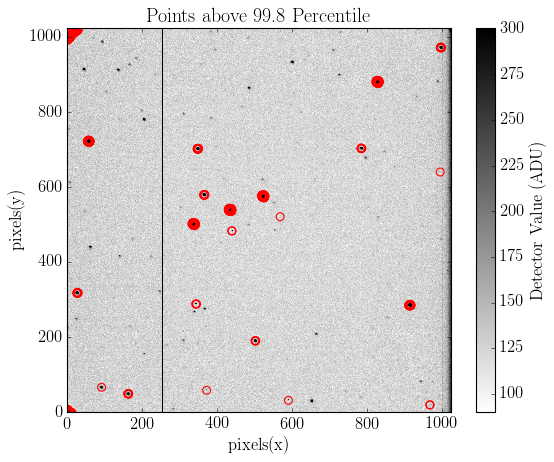

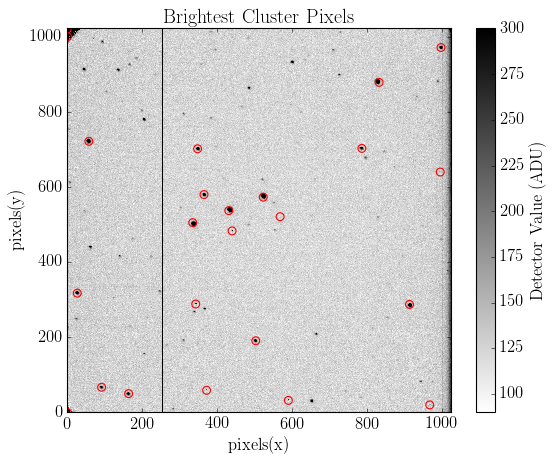

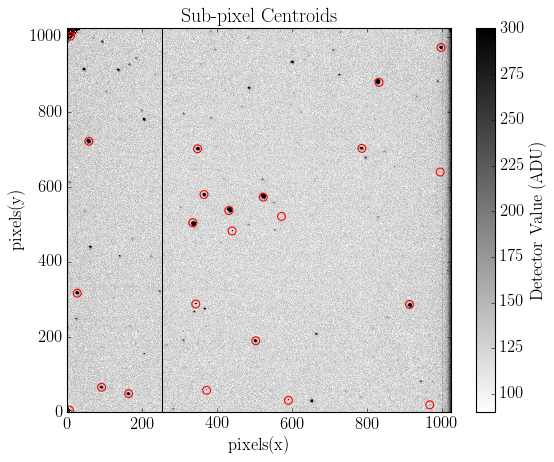

In [4]:
perc = 99.8
star_pts = findStar(red, perc=perc)

bad_col = [255, 256] + list(np.arange(1000,1025))
ptlist = removePixels(star_pts, cols=bad_col)

clusters = clusterPoints(ptlist, radius=5)
peak_pixels = findClusterMax(red, clusters)
centroids = centroid(red, peak_pixels, radius=20)

plotImg(red, pts=ptlist.T, rng=[90,300], title='Points above %s Percentile'%(perc), \
        save='writeup/plots/identification1.png')
plotImg(red, pts=peak_pixels.T, rng=[90,300], title='Brightest Cluster Pixels', \
        save='writeup/plots/identification2.png')
plotImg(red, pts=centroids.T, rng=[90,300], title='Sub-pixel Centroids', \
        save='writeup/plots/identification3.png')

Calling Vizier http://webviz.u-strasbg.fr/viz-bin/asu-tsv/?-source=USNO-B1&-c.ra=266.209583&-c.dec=0.000000&-c.bm=4.0000000/4.0000000&-out.max=unlimited


/home/jess/Desktop/Academic/PHYS164/lab3/query.py:70: RuntimeWarning: invalid value encountered in less
  w = np.where(rmag < rcut)[0] # select only bright stars r < 15 mag.


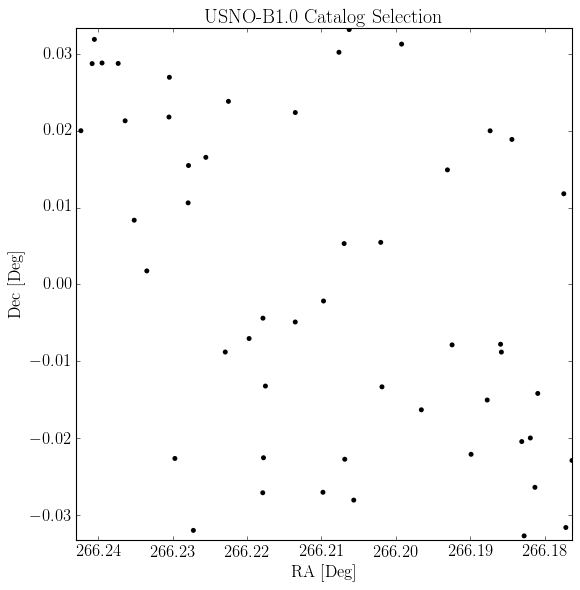

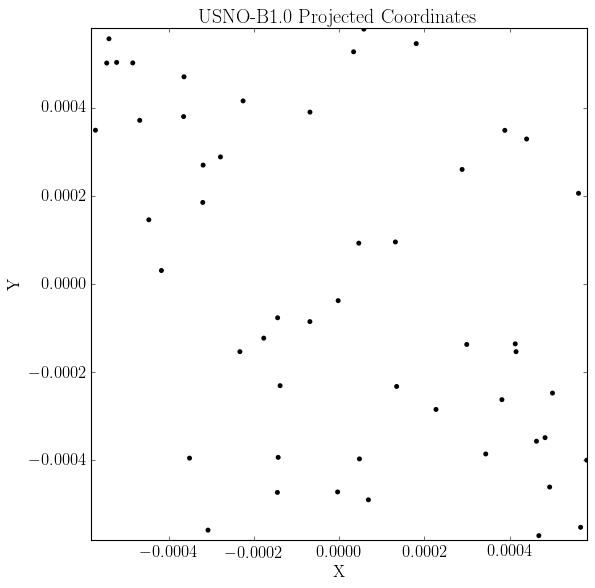

In [6]:
fovam = 4
name, rad, ded, rmag = selectField(file='data/demo/d158.fits', fovam=fovam, rmag=18, plot=True)

hdr = fits.getheader('data/demo/d158.fits')
ra0, dec0 = formatRADEC(hdr['RA'], hdr['DEC'])

X, Y = angleToProjected(ra0=ra0, dec0=dec0, ra=rad, dec=ded, fovam=fovam)

In [7]:
x = centroids.T[0]
y = centroids.T[1]
xideal, yideal = projectedToPixelIdeal(X, Y, f_p=16480/0.015)

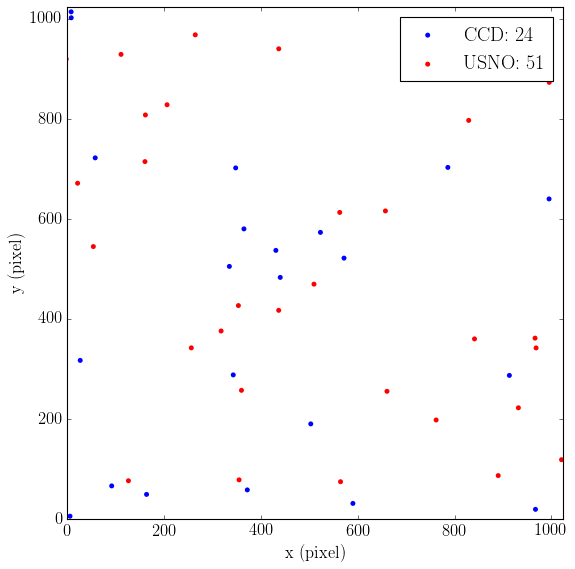

In [44]:
plt.figure(figsize=[8,8])
plt.scatter(x, y, color='b', edgecolor='none', label='CCD: %s'%(len(x)))
plt.scatter(xideal, yideal, color='r', edgecolor='none', label='USNO: %s'%(len(xideal)))
plt.xlim(0,1024)
plt.ylim(0,1024)
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
plt.legend(loc='upper right', scatterpoints=1)
plt.show()

In [157]:
def matchCoord(x, y, X, Y, **kwargs):

    N = len(x)
    M = len(X)
    
    img_size = kwargs.get('img_size', 1024)
    
    match_X, match_Y = [], []
    for i in range(N):
        dist_i = []
        for j in range(M):
            dist_i.append(dist((x[i],y[i]), (X[j],Y[j])))
        closest = np.where(dist_i == min(dist_i))[0]
        match_X.append(X[closest][0])
        match_Y.append(Y[closest][0])
        
    return np.array(match_X), np.array(match_Y)

def removeMatches(x, y, xmatch, ymatch, **kwargs):
    
    if len(x) != len(xmatch):
        return
    else: N = len(x)
    
    img_size = kwargs.get('img_size', 1024)
    
    #Remove matches outside the image boundary
    xm1, ym1, xm2, ym2 = [], [], [], []
    for i in range(N):
        if (0 < xmatch[i] < img_size) & (0 < ymatch[i] < img_size):
            xm1.append(x[i])
            xm2.append(xmatch[i])
            ym1.append(y[i])
            ym2.append(ymatch[i])

    #Remove duplicate CCD points       
    xdict = {xm1[i]:xm2[i] for i in range(len(xm1))}
    ydict = {ym1[i]:ym2[i] for i in range(len(xm1))}
    
    xrev, yrev = {}, {}
    for k, v in xdict.items():
        xrev[v] = xrev.get(v, [])
        xrev[v].append(k)
    for k, v in ydict.items():
        yrev[v] = yrev.get(v, [])
        yrev[v].append(k)

    xc1, yc1, xc2, yc2 = [], [], [], []
    nset = len(xrev)
    for i in range(nset):
        #catalog
        key_x, key_y = xm2[i], ym2[i] 
        #ccd, list with multiples
        items_x, items_y = xrev[key_x], yrev[key_y] 
        nitems = len(items_x)
        
        dist_i = []
        for m in range(nitems):
            ccdm = [items_x[m], items_y[m]]
            catm = [key_x, key_y]
            dist_i.append(dist(ccdm, catm))
        close_idx = np.where(dist_i == min(dist_i))[0][0]
        #ccd 
        xc1.append(items_x[close_idx])
        yc1.append(items_y[close_idx])
        #catalog
        xc2.append(key_x)
        yc2.append(key_y)
            
    return xc1, yc1, xc2, yc2

def plotMatch(x, y, xmatch, ymatch, **kwargs):
    
    img_size = kwargs.get('img_size', 1024)
    
    lines = [[(x[i], y[i]), (xmatch[i], ymatch[i])] for i in range(len(x))]
    lc = mc.LineCollection(lines, colors='k', linewidths=1, alpha=.5)
    fig, ax = plt.subplots(figsize=[8,8])
    ax.add_collection(lc)

    plt.scatter(x, y, color='b', edgecolor='none', label='CCD: %s'%(len(x)))
    plt.scatter(xmatch, ymatch, color='r', edgecolor='none', label='USNO: %s'%(len(xmatch)))
    plt.xlim(0,img_size)
    plt.ylim(0,img_size)
    plt.xlabel('x (pixel)')
    plt.ylabel('y (pixel)')
    plt.legend(loc='upper right', scatterpoints=1)
    plt.show()

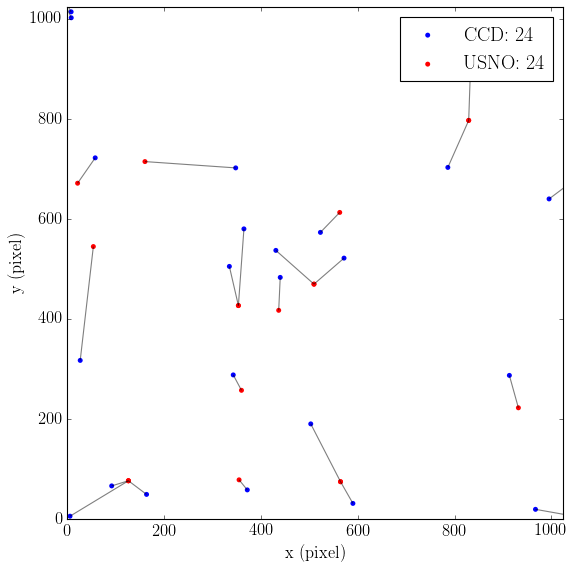

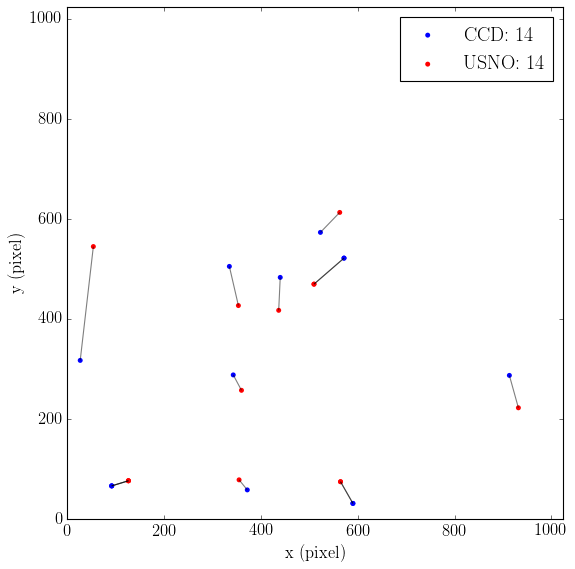

In [158]:
xmatch, ymatch = matchCoord(x, y, xideal, yideal)
plotMatch(x, y, xmatch, ymatch)

xm1, ym1, xm2, ym2 = removeMatches(x, y, xmatch, ymatch)
plotMatch(xm1, ym1, xm2, ym2)